In [ ]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


In [3]:
class DepthDataSet(data.Dataset):
    def __init__(self, path, depth=False):
        # self.files = glob.glob(f"{path}/*.tar.gz")
        self.paths = path
        self.path_file_map = []
        self.data = []
        self.files = os.listdir(path)
        self.labels = []
        self.depth = depth

        # print(self.files)
        for file in self.files:
            # with tarfile.open(file, 'r') as f:
                # data = pd.read_csv(f)
            with tarfile.open(f'{path}/{file}','r:gz') as f:
                for member in f.getmembers():
                    if f.extractfile(member):    
                        self.data.append(member)
                        # print(member)
                        label = os.path.basename(os.path.dirname(member.name))
                        # print(label)
                        
                        #map the label of the image to the correct file
                        self.labels.append(label)
                        self.path_file_map.append(file)


        # self.label_to_index = {label: i for i, label in enumerate(sorted(set(self.labels)))}

                # print(f.extractall())
                # t_file = f.ex
                # for tarfile in f.extractall():
                    # print(tarfile)
                # self.data.extend([img for img in f.getmembers()])
                # data = pd.read_csv(f.extractall,compression='gzip', header=0, sep=' ', quotechar='"', encoding=bytes)    
                # self.data.append(data)
        
        # self.data = pd.concat(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path = self.path_file_map[index]
        # print('path =',path)

        # path = "Train400Img.tar.gz" if self.labels[index] == "" else self.labels[index]

        # print('data =',self.data[index])
        
        with tarfile.open(f'{self.paths}/{path}', 'r:gz') as tf:
            file = tf.extractfile(self.data[index])
            
            # image = tf.getmember(self.data[index])
            if(self.depth == False):
                img = Image.open(io.BytesIO(file.read()))
                toTensor = transforms.ToTensor()
                img = toTensor(img)
            # label = self.label_to_index[self.labels[index]]
                # if(torch.cuda.is_available()):
                #     img = img.to('cuda')
                # print(img)
                return img
        
            else:
                img = loadmat(io.BytesIO(file.read()))
                # matObj = plt.mat    
                # print(img)

                img = img.get("Position3DGrid")
                
                depth = img[:,:,3]
                depth = np.log1p(depth)

                target = (1704,2272)

                depth_resized = cv.resize(depth, target, interpolation=cv.INTER_CUBIC)
                depth_resized = cv.normalize(depth_resized, None, 0, 255, cv.NORM_MINMAX)
                depth_resized = depth_resized.astype(np.uint8)

                depth_resized = np.expand_dims(depth_resized,axis=2)

                depth_resized = torch.from_numpy(depth_resized).permute(2,0,1).float() / 255.0

                # if(torch.cuda.is_available()):
                #     depth_resized = depth_resized.to('cuda')
                
                # print(depth_resized)

                # depth = img[:,:,3]
                # max_depth = depth.max()
                # depth = Image.fromarray(depth.astype(np.float32))
                # print(depth)

                # # print(depth)
                # depth = depth/max_depth
                
                # print(depth)

                # depth = depth.resize((2272,1704))
                # print(img)
                # print(img[:,:,2])
                return depth_resized

In [4]:
train_img_dataset = DepthDataSet(path='./data/train/imgs')

In [5]:
train_depth_dataset = DepthDataSet(path='./data/train/depths',depth=True)

In [ ]:
index=69
image = train_img_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth_map = train_depth_dataset[index]
depth_map = depth_map.cpu().permute(1,2,0).numpy()
plt.imshow(depth_map)
plt.show()

In [54]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()

        #(2272, 1704, 3) -> (2272, 1704, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=2,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        

        #(568, 426, 32) -> (568, 426, 64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )


        #(284, 213, 64) -> (95, 71, 32)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=4,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True)
        )
        #flatten

        self.fully_c1 = nn.Sequential(
            nn.Linear(4*72*54,4*36*27),
            # nn.BatchNorm1d(4*36*27),
            nn.ReLU(inplace=True)
        )
        # self.fully_c2 = nn.Sequential(
        #     nn.Linear(25*16*8, 10*8*4)
        # )
        # self.fully_c3 = nn.Linear(20*16*8, 5*4*2)

    def forward(self, x):
        # print("{:20s} {}".format("Input Shape:",np.shape(x)))

        x = self.conv1(x)
        # print("{:20s} {}".format("Conv1:",np.shape(x)))

        x = self.conv2(x)
        # print("{:20s} {}".format("Conv2:",np.shape(x)))

        x = self.conv3(x)
        # print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = self.conv4(x)
        # print("{:20s} {}".format("Conv4:",np.shape(x)))

        x = self.conv5(x)
        # print("{:20s} {}".format("Conv5:",np.shape(x)))

        # print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = torch.flatten(x, 1)
        # print("{:20s} {}".format("Flatten:",np.shape(x)))

        x = self.fully_c1(x)
        # print("{:20s} {}".format("Fully Conn L1:",np.shape(x)))

        # x = self.fully_c2(x)
        # print("{:20s} {}".format("Fully Conn L2:",np.shape(x)))

        # x = self.fully_c3(x)
        # print("{:20s} {}".format("Fully Connected Layer 3:",np.shape(x)))
        return x


In [76]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # self.fully_c2 = nn.Sequential(
        #     nn.Linear(8*29*22,8*29*22)
        # )

        self.fully_c1 = nn.Sequential(
            nn.Linear(4*36*27,4*72*54),
            # nn.BatchNorm1d(8*143*107),
            nn.ReLU(inplace=True)
        )

        #unflatten
        self.unflatten = nn.Unflatten(1,(4,72,54))

        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4,out_channels=8,kernel_size=3,stride=3,padding=1),
            nn.AdaptiveAvgPool2d((143, 107)),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((285,214)),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        #(284, 213, 64) -> (95, 71, 32)
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((569,427)),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )

        #(568, 426, 32) -> (568, 426, 64)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8,out_channels=4,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((1137,853)),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True)
        )

        #(2272, 1704, 3) -> (2272, 1704, 16)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4,out_channels=1,kernel_size=3,stride=2,padding=1),
            nn.AdaptiveAvgPool2d((2272,1704)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
            # nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        # print("{:20s} {}".format("Input Shape:",np.shape(x)))
        
        # x = self.fully_c2(x)
        # # print("{:20s} {}".format("Fully Conn L2:",np.shape(x)))
        
        x = self.fully_c1(x)
        # print("{:20s} {}".format("Fully Conn L1:",np.shape(x)))

        x = self.unflatten(x)
        # print("{:20s} {}".format("Unflatten:",np.shape(x)))

        
        x = self.conv5(x)
        # print("{:20s} {}".format("Conv5:",np.shape(x)))

        x = self.conv4(x)
        # print("{:20s} {}".format("Conv4:",np.shape(x)))
        
        x = self.conv3(x)
        # print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = self.conv2(x)
        # print("{:20s} {}".format("Conv2:",np.shape(x)))

        x = self.conv1(x)
        # print("{:20s} {}".format("Conv1:",np.shape(x)))

        #map values 0 to 1
        # x = torch.sigmoid(x)

        # x = self.fully_c3(x)
        # print("{:20s} {}".format("Fully Connected Layer 3:",np.shape(x)))
        return x


In [77]:
encoder = Encoder()
encoder = encoder.to(device)
summary(encoder, (3,2272, 1704))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 16, 1137, 853]             448
       BatchNorm2d-2        [-1, 16, 1137, 853]              32
              ReLU-3        [-1, 16, 1137, 853]               0
            Conv2d-4         [-1, 32, 569, 427]           4,640
       BatchNorm2d-5         [-1, 32, 569, 427]              64
              ReLU-6         [-1, 32, 569, 427]               0
            Conv2d-7         [-1, 16, 285, 214]           4,624
       BatchNorm2d-8         [-1, 16, 285, 214]              32
              ReLU-9         [-1, 16, 285, 214]               0
           Conv2d-10          [-1, 8, 143, 107]           1,160
      BatchNorm2d-11          [-1, 8, 143, 107]              16
             ReLU-12          [-1, 8, 143, 107]               0
           Conv2d-13            [-1, 4, 72, 54]             292
      BatchNorm2d-14            [-1, 4,

In [78]:
decoder = Decoder()
decoder = decoder.to(device)
summary(decoder, (3888,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 15552]      60,481,728
              ReLU-2                [-1, 15552]               0
         Unflatten-3            [-1, 4, 72, 54]               0
   ConvTranspose2d-4          [-1, 8, 214, 160]             296
 AdaptiveAvgPool2d-5          [-1, 8, 143, 107]               0
       BatchNorm2d-6          [-1, 8, 143, 107]              16
              ReLU-7          [-1, 8, 143, 107]               0
   ConvTranspose2d-8         [-1, 16, 285, 213]           1,168
 AdaptiveAvgPool2d-9         [-1, 16, 285, 214]               0
      BatchNorm2d-10         [-1, 16, 285, 214]              32
             ReLU-11         [-1, 16, 285, 214]               0
  ConvTranspose2d-12          [-1, 8, 569, 427]           1,160
AdaptiveAvgPool2d-13          [-1, 8, 569, 427]               0
      BatchNorm2d-14          [-1, 8, 5

In [79]:
img_dataloader = DataLoader(train_img_dataset,batch_size=4,shuffle=True)
depth_dataloader = DataLoader(train_depth_dataset,batch_size=4,shuffle=True)

In [80]:
sample = encoder(next(iter(img_dataloader)).to(device))
decoder(sample)

tensor([[[[3.3764e-01, 3.3857e-01, 5.5564e-02,  ..., 3.3243e-01,
           6.7887e-01, 6.6310e-01],
          [3.5527e-01, 2.3916e-01, 2.4050e-02,  ..., 3.0253e-01,
           7.8408e-01, 8.3536e-01],
          [3.9918e-01, 5.9545e-01, 4.5121e-01,  ..., 8.6140e-02,
           3.7894e-02, 2.0838e-01],
          ...,
          [5.8108e-02, 6.7588e-04, 2.4228e-04,  ..., 3.6047e-02,
           4.3972e-01, 7.1903e-02],
          [8.4265e-01, 7.7239e-01, 8.0550e-01,  ..., 3.5633e-01,
           5.3389e-01, 2.7987e-01],
          [8.9417e-01, 9.6004e-01, 9.0833e-01,  ..., 4.0562e-01,
           5.7072e-01, 6.3338e-01]]],


        [[[4.5220e-01, 1.8292e-01, 4.7872e-02,  ..., 6.5868e-01,
           5.0175e-01, 5.4956e-01],
          [4.3773e-01, 8.6780e-02, 3.3767e-02,  ..., 4.9681e-01,
           6.4149e-01, 7.7249e-01],
          [8.1894e-01, 7.4167e-01, 7.7670e-01,  ..., 1.5895e-01,
           1.3773e-01, 3.5788e-01],
          ...,
          [2.8019e-02, 9.8490e-04, 4.2317e-04,  ..., 3.90

In [ ]:
def save_check(epoch, model, optimizer, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f'Saved model at epoch:{epoch}')

In [ ]:
def train(encoder,decoder,img_dataloader,depth_dataloader,optimizer,loss, scheduler, epochs=2):
    encoder.train()
    decoder.train()

    for epoch in range(epochs):
        total_loss = 0.0
        batch_num = 0
        for data,depth_data in zip(img_dataloader,depth_dataloader):

            batch_num+=1
            
            inputs = data
            ground_truth = depth_data

            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            optimizer.zero_grad()

            encoded = encoder(inputs)
            decoded = decoder(encoded)

            loss_val = loss(decoded,ground_truth)

            loss_val.backward()

            optimizer.step()
            
            curr_loss = loss_val.item()
            total_loss+= curr_loss

            torch.cuda.empty_cache()
            print("Batch:{:3d}/{:3d}{:10}Loss{:10f}{:10}{:2d}/{:2d}".format(batch_num,len(img_dataloader),"",curr_loss,"",epoch,epochs))
        scheduler.step()
        save_check(epoch,decoder,optimizer,loss,f"./models/checkpoints/decoder_{epoch}.pth")
        save_check(epoch,encoder,optimizer,loss,f"./models/checkpoints/encoder_{epoch}.pth")
        print("Epoch {:10d}{:10}Loss:{:10f}".format(epoch,"",total_loss/len(img_dataloader)))            

In [81]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,gamma=0.1)

In [82]:
train(encoder,decoder,img_dataloader,depth_dataloader,optimizer,loss,scheduler,epochs=4)

Batch:  1/100          Loss  0.124399           0/ 4


KeyboardInterrupt: 

In [ ]:
torch.save(encoder.state_dict(),"./models/saved/encoder.pth")
torch.save(decoder.state_dict(),'./models/saved/decoder.pth')

In [73]:
encoder.eval()
decoder.eval()

Decoder(
  (fully_c1): Sequential(
    (0): Linear(in_features=3888, out_features=15552, bias=True)
    (1): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(4, 72, 54))
  (conv5): Sequential(
    (0): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): AdaptiveAvgPool2d(output_size=(143, 107))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): AdaptiveAvgPool2d(output_size=(285, 214))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): AdaptiveAvgPool2d(output_size=(569, 427))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3)

In [74]:
imgs = next(iter(img_dataloader))

encoded_imgs = encoder(imgs.to(device))
decoded_imgs = decoder(encoded_imgs)

# for i in range(decoded_imgs.shape)

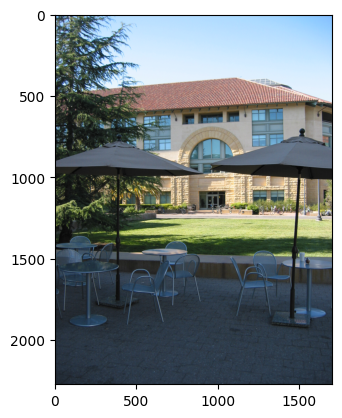

mean:55.45597325886067
var:229.319600547903
max:255


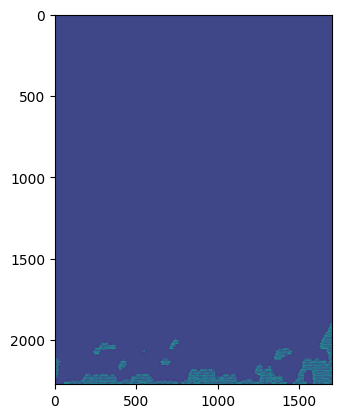

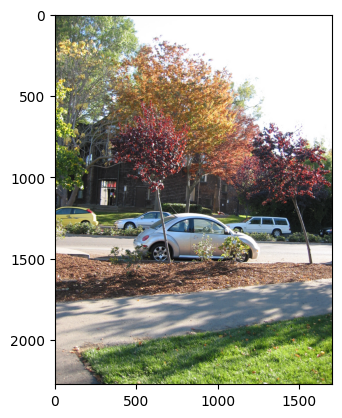

mean:54.907130281690144
var:494.84193654997756
max:255


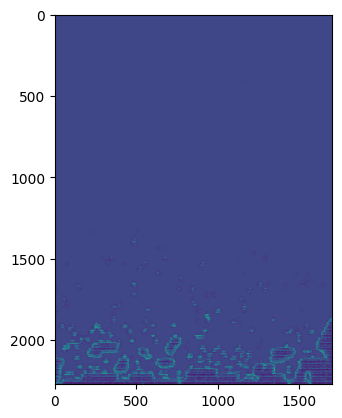

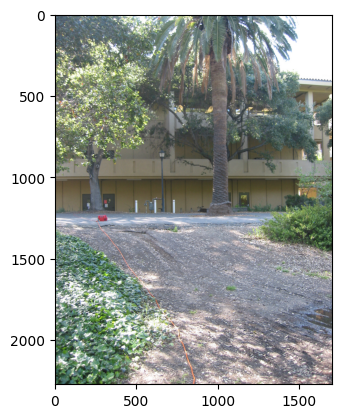

mean:54.248906880248626
var:0.4476008640391527
max:58


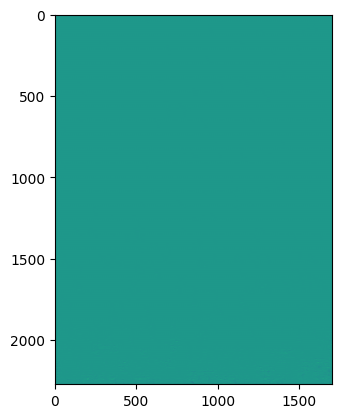

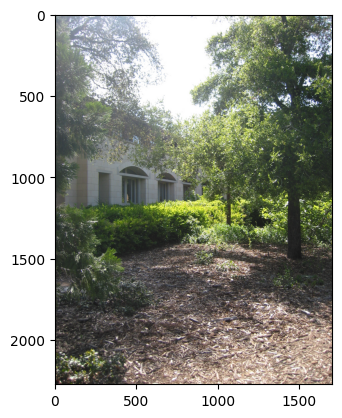

mean:54.66429806833961
var:414.9684011969783
max:255


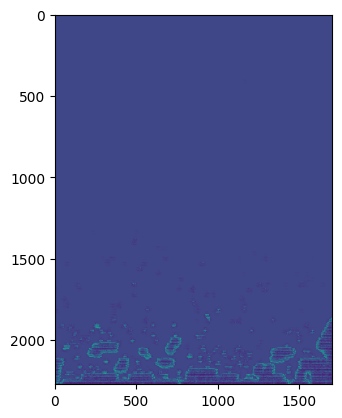

In [75]:
decoded_imgs = decoded_imgs.to("cpu")
decoded_imgs = decoded_imgs.detach()
for i in range(decoded_imgs.shape[0]):
    plt.imshow(imgs[i].permute(1,2,0))
    plt.show()
    depth = np.array(decoded_imgs[i].permute(1,2,0)*255,dtype=np.uint8)
    print(f"mean:{np.mean(depth)}\nvar:{np.var(depth)}\nmax:{np.max(depth)}")
    plt.imshow(depth)
    plt.show()